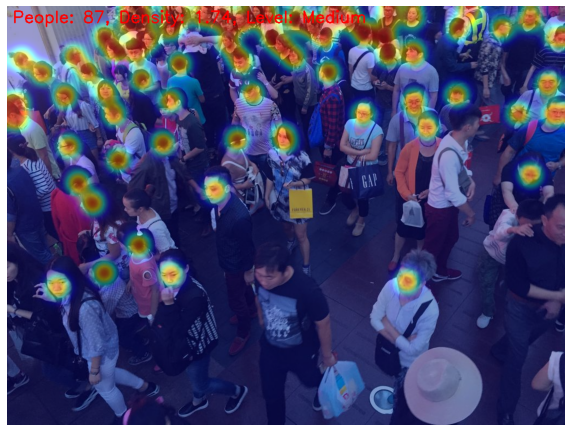

Heatmap saved as heatmap_image_00044.jpg


In [1]:
from ultralytics import YOLOv10
import supervision as sv
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
# 定义分类标签
classes = {0: 'person'}

# 加载模型
model = YOLOv10('runs/detect/train_yolov10b/weights/best.pt')

# 读取图像
image_path = 'image_00044.jpg'
image = cv2.imread(image_path)

# 进行预测
results = model(source=image, conf=0.25, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results)

# 计算人数和密度
num_people = len([class_id for class_id in detections.class_id if class_id == 0])  # 统计识别到的person数量
area_m2 = 50  # 摄像头区域的面积
density_per_m2 = num_people / area_m2  # 计算密度（每平方米人数）

# 定义密度等级函数
def get_density_level(density_per_m2):
    if density_per_m2 < 0.83:
        return "Very Low"
    elif density_per_m2 < 1.53:
        return "Low"
    elif density_per_m2 < 2.5:
        return "Medium"
    elif density_per_m2 < 3.3:
        return "High"
    elif density_per_m2 < 5.5:
        return "Very High"
    else:
        return "Extremely High"

# 获取密度等级
density_level = get_density_level(density_per_m2)

# 创建一个副本来标注图像
annotated_image = image.copy()

# 创建与原始图像大小相同的空白热力图
heatmap = np.zeros((image.shape[0], image.shape[1]), dtype=np.float32)

# 在图像上标记中心点并生成热力图
for box in detections.xyxy:  # 检测框的格式为 (xmin, ymin, xmax, ymax)
    xmin, ymin, xmax, ymax = box[:4]  # 获取边界框的坐标
    x_center = int((xmin + xmax) / 2)
    y_center = int((ymin + ymax) / 2)
    
    # 绘制圆形热点区域
    cv2.circle(heatmap, (x_center, y_center), radius=20, color=1, thickness=-1)  # 半径20的圆，值为1

# 使用高斯模糊平滑热力图
heatmap = cv2.GaussianBlur(heatmap, (75, 75), sigmaX=0)

# 将热力图标准化到 0-255 范围
heatmap = np.uint8(255 * heatmap / np.max(heatmap))

# 将热力图转换为彩色图像
heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 将热力图叠加到原始图像上
overlay = cv2.addWeighted(annotated_image, 0.6, heatmap_color, 0.4, 0)

# 显示人数、密度和密度等级（红色显示）
text = f"People: {num_people}, Density: {density_per_m2:.2f}, Level: {density_level}"
cv2.putText(overlay, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)  # 红色文本

# 获取图像的文件名和目录
directory, filename = os.path.split(image_path)
output_path = os.path.join(directory, f"heatmap_{filename}")

# 设置图像尺寸（宽度, 高度），单位为英寸
plt.figure(figsize=(10, 8))  # 设置为 10 x 8 英寸

# 使用 matplotlib 在 Jupyter Notebook 中显示热力图
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.axis('off')  # 关闭坐标轴
plt.show()

# 保存标注后的图像（含热力图）
cv2.imwrite(output_path, overlay)
print(f"Heatmap saved as {output_path}")
